In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Load the data (assuming it's in .csv format from Kaggle)
# Adjust the file path as needed
data = pd.read_csv("mitbih_train.csv")
test = pd.read_csv("mitbih_test.csv")

# Check the data shape and distribution
print(f"Training data shape: {data.shape}")
print(f"Testing data shape: {test.shape}")

# Examine class distribution
print(data.iloc[:, -1].value_counts())

# Check class distribution
class_distribution = data.iloc[:, -1].value_counts()
print("Class distribution in training data:")
print(class_distribution)

ModuleNotFoundError: No module named 'sklearn'

In [6]:
# Visualize class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x=data.iloc[:, -1])
plt.title('Class Distribution')
plt.xlabel('Class')
plt.xticks(ticks=range(5), labels=['N: Normal', 'S: Supraventricular', 'V: Ventricular', 'F: Fusion', 'Q: Unknown'])
plt.show()

NameError: name 'data' is not defined

<Figure size 1000x600 with 0 Axes>

In [3]:
# Plot examples of each class
def plot_examples(data, classes):
    fig, axs = plt.subplots(len(classes), 1, figsize=(12, 8))
    for i, cls in enumerate(classes):
        sample = data[data.iloc[:, -1] == i].iloc[0, :-1].values
        axs[i].plot(sample)
        axs[i].set_title(f"Class {cls}")
    plt.tight_layout()
    plt.show()

# Define class names
class_names = ['N: Normal', 'S: Supraventricular', 'V: Ventricular', 'F: Fusion', 'Q: Unknown']
plot_examples(data, class_names)

NameError: name 'data' is not defined

In [4]:
X = data.iloc[:, :-1].values
print(X[0])

NameError: name 'data' is not defined

In [5]:
# Split features and target
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values
X_test = test.iloc[:, :-1].values
y_test = test.iloc[:, -1].values

# Reshape for CNN input (samples, timesteps, features)
X = X.reshape(X.shape[0], X.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encode the labels
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, num_classes=5)
y_test = to_categorical(y_test, num_classes=5)

# Split training data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight
y_integers = np.argmax(y_train, axis=1)
class_weights = compute_class_weight('balanced', classes=np.unique(y_integers), y=y_integers)
class_weights_dict = dict(enumerate(class_weights))
print("Class weights:", class_weights_dict)

Class weights: {0: 0.24197053184322803, 1: 7.760886426592798, 2: 3.000942587832048, 3: 28.647034764826177, 4: 2.7006747638326587}


In [ ]:
# Import Keras components
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, Flatten, Dropout, Input
from tensorflow.keras.layers import BatchNormalization, Add, Activation, GlobalAveragePooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
# Function to create a residual block
def residual_block(x, filters, kernel_size=3):
    shortcut = x
    
    # First convolutional layer
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    # Second convolutional layer
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    
    # If input shape doesn't match output shape, adjust shortcut
    if shortcut.shape[-1] != filters:
        shortcut = Conv1D(filters, 1, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    
    # Add shortcut to output
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

# Build an enhanced model with residual connections
def build_resnet_model(input_shape, num_classes=5):
    inputs = Input(shape=input_shape)
    
    # Initial convolutional layer
    x = Conv1D(64, 7, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    
    # Residual blocks
    x = residual_block(x, 64)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = residual_block(x, 128)
    x = MaxPooling1D(pool_size=2)(x)
    x = Dropout(0.2)(x)
    
    x = residual_block(x, 256)
    x = Dropout(0.3)(x)
    
    # Global pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
# Create the model
input_shape = (X_train.shape[1], 1)
model = build_resnet_model(input_shape)

In [ ]:
# Compile with a lower learning rate for better convergence
optimizer = Adam(learning_rate=0.0003)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 187, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 187, 64)   │        512 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 187, 64)   │        256 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 187, 64)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 93, 64)    │          0 │ activation[0][0]  │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 93, 64)    │     12,352 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 93, 64)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 93, 64)    │     12,352 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 93, 64)    │        256 │ conv1d_2[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 93, 64)    │          0 │ batch_normalizat… │
│                     │                   │            │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 93, 64)    │          0 │ add[0][0]         │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 46, 64)    │          0 │ activation_2[0][… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 46, 64)    │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 46, 128)   │     24,704 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 46, 128)   │        512 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 46, 128)   │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 46, 128)   │     49,280 │ activation_3[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 46, 128)   │      8,320 │ dropout[0][0]   

 Total params: 475,397 (1.81 MB)

 Trainable params: 472,453 (1.80 MB)

 Non-trainable params: 2,944 (11.50 KB)

In [ ]:
# Define callbacks for better training
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


model_checkpoint = ModelCheckpoint(
    'best_ecg_model.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)


# Learning rate reduction when training plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=5,
    min_lr=0.00001,
    verbose=1
)

In [ ]:
# Train the model with class weights to handle imbalance
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=70,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint, reduce_lr],
    class_weight=class_weights_dict,
    verbose=1
)

Epoch 1/60
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3917 - loss: 1.0408
Epoch 1: val_accuracy improved from -inf to 0.55371, saving model to best_ecg_model.keras
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 98s 40ms/step - accuracy: 0.3917 - loss: 1.0407 - val_accuracy: 0.5537 - val_loss: 1.1585 - learning_rate: 3.0000e-04
Epoch 2/60
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6953 - loss: 0.5522
Epoch 2: val_accuracy did not improve from 0.55371
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 80s 37ms/step - accuracy: 0.6953 - loss: 0.5522 - val_accuracy: 0.5151 - val_loss: 0.9708 - learning_rate: 3.0000e-04
Epoch 3/60
2188/2189 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.7626 - loss: 0.4693
Epoch 3: val_accuracy improved from 0.55371 to 0.73914, saving model to best_ecg_model.keras
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 85s 39ms/step - accuracy: 0.7626 - loss: 0.4693 - val_accuracy: 0.7391 - val_loss: 0.6329 - learning_rate: 3.0000e-04
Epoch 4/60
2189/2189 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/st

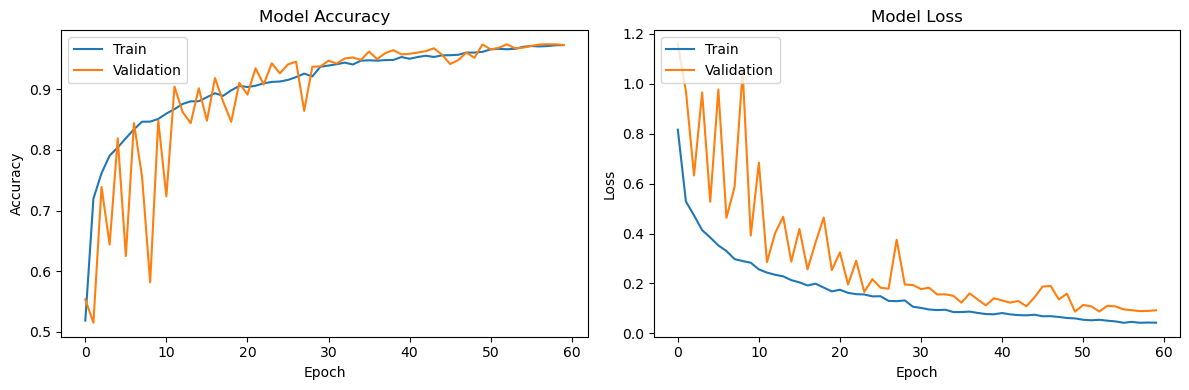

In [ ]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_test_classes = np.argmax(y_test, axis=1)

# Define class names for reporting
class_names = ['N: Normal', 'S: Supraventricular', 'V: Ventricular', 'F: Fusion', 'Q: Unknown']

# Generate detailed classification report
print("\nClassification Report:")
print(classification_report(y_test_classes, y_pred_classes, target_names=class_names))

685/685 ━━━━━━━━━━━━━━━━━━━━ 8s 11ms/step - accuracy: 0.9758 - loss: 0.0755
Test accuracy: 0.9757
685/685 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step

Classification Report:
                     precision    recall  f1-score   support

          N: Normal       1.00      0.98      0.99     18117
S: Supraventricular       0.70      0.89      0.78       556
     V: Ventricular       0.95      0.96      0.96      1448
          F: Fusion       0.52      0.95      0.67       162
         Q: Unknown       0.98      0.99      0.99      1608

           accuracy                           0.98     21891
          macro avg       0.83      0.95      0.88     21891
       weighted avg       0.98      0.98      0.98     21891



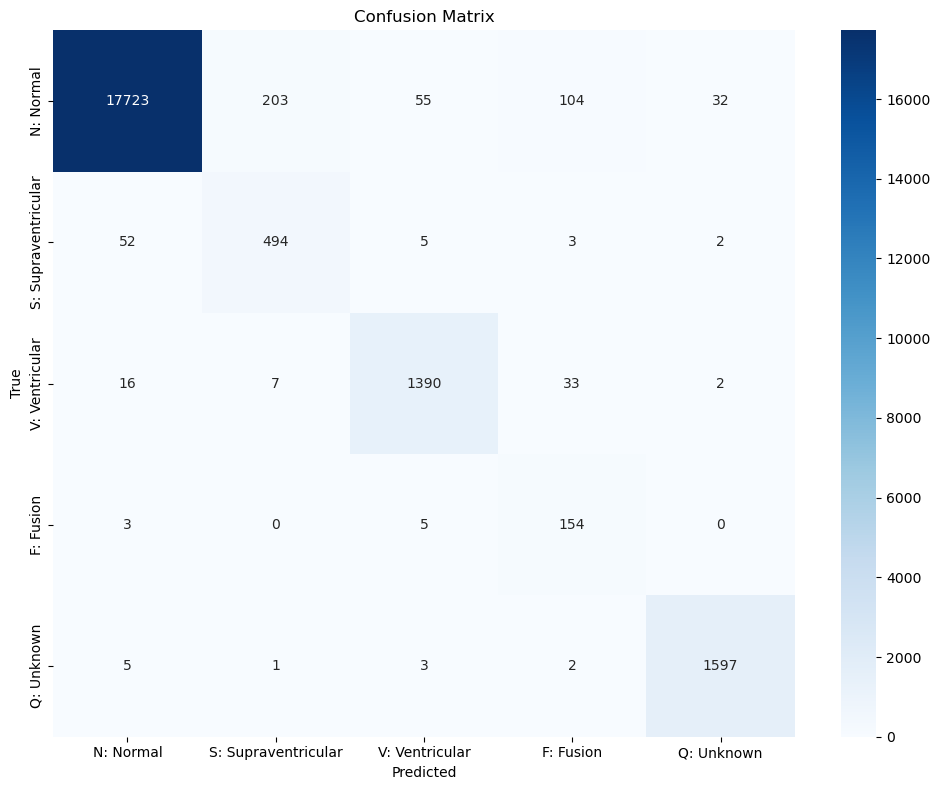

Accuracy for class N: Normal: 0.9783
Accuracy for class S: Supraventricular: 0.8885
Accuracy for class V: Ventricular: 0.9599
Accuracy for class F: Fusion: 0.9506
Accuracy for class Q: Unknown: 0.9932


In [ ]:
# Create and plot confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# Compute per-class accuracy
per_class_accuracy = cm.diagonal() / cm.sum(axis=1)
for i, acc in enumerate(per_class_accuracy):
    print(f"Accuracy for class {class_names[i]}: {acc:.4f}")

In [ ]:
model_json = model.to_json()
with open("ecg.json", "w") as json_file:
    json_file.write(model_json)

model.save('ecg_detection_model.h5')
model.save('ecg_detection_model.keras')

print("Model saved as DDD_model.h5")